# AN2DL - Second Challenge

## Initial Operations

### Import the libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

### Set seed for reproducibility

In [ ]:
seed = 69
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset = pd.read_csv('training.csv') 

## Model

### Normalization

In [ ]:
X_train_raw = dataset.copy()

# Normalize both train and test samples
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)

### Define Sequences

In [ ]:
target_labels = dataset.columns
window = 100
stride = 10
telescope = 48

In [ ]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)

### Define the Model

In [ ]:
input_shape = X_train.shape[1:]   #The window 
output_shape = y_train.shape[1:]  #The telescope 
batch_size = 64
epochs = 35

In [ ]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    layer = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True))(input_layer)
    layer = tfkl.Conv1D(64, 3, padding='same', activation='relu')(layer)
    layer = tfkl.MaxPool1D()(layer)
    layer = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True))(layer)
    layer = tfkl.Conv1D(128, 6, padding='same', activation='relu')(layer)
    layer = tfkl.MaxPool1D()(layer)
    layer = tfkl.Bidirectional(tfkl.GRU(256, return_sequences=True))(layer)
    layer = tfkl.Conv1D(256, 12, padding='same', activation='relu')(layer)
    layer = tfkl.GlobalAveragePooling1D()(layer)
    layer = tfkl.Dropout(.25)(layer)
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(layer)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         28032     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 64)           0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 256)          148992    
 nal)                                                            
                                                             

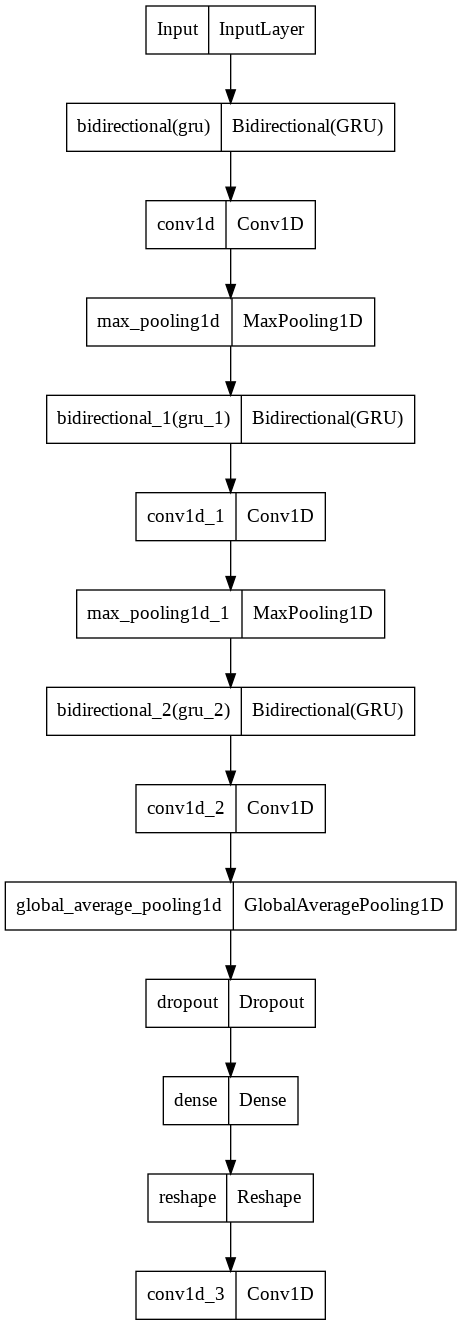

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

### Save the model

In [ ]:
model.save("ModelD.hdf5")